# Explainability of Unsupervised Anomaly Detection Models
#### Writer: Hamidreza Salahi
#### Date: July 2024 (Week 3)

## 1. Overview

This notebook investigates the explainability of unsupervised machine learning models for outlier detection. The goal is to make the results of these models understandable to end users by employing various visualization techniques and explainability methods. Specifically, this notebook will cover:

**Introduction to Explainability in Outlier Detection:**

- Importance of explainability
- Overview of common techniques

**Dataset and Preprocessing:**

- Description of the dataset(s) used
- Preprocessing steps

**Anomaly Detection Models:**

- List of unsupervised models employed (e.g., Isolation Forest, LOF, KNN)
- Brief description of each model

**Explainability Techniques:**

- Introduction to SHapley Additive exPlanations (SHAP)
- Implementation of SHAP for selected models
- Other visualization techniques (e.g., feature importance, partial dependence plots)

**Results and Analysis:**

- Comparative analysis of model explanations
- Visualizations of model outputs and SHAP values
- Discussion of findings

**Conclusion:**

- Summary of key insights
- Future directions for improving explainability in outlier detection

By the end of this notebook, it is hoped that I will gain a better understanding of how to interpret the results of unsupervised anomaly detection models and the role of explainability in enhancing their usability.








## 1. Introduction
### 1.1 Background
**Explainability in Anomaly Detection**

 For anomaly detection models, understanding why certain data points are flagged as anomalies is crucial for validating model results and making informed decisions. Explainability provides insights into the model’s decision-making process, which is essential for trust and transparency.

**Importance of Explainability**

Explainability helps stakeholders understand the rationale behind model predictions, which is particularly important in high-stakes applications like fraud detection. Without clear explanations, users may misinterpret model results or lack confidence in the system’s recommendations. Effective explainability can improve model adoption and ensure that decisions based on the model are well-informed and justifiable.


### 1.2 Objectives

**Research Goals**

- To investigate methods for explaining and visualizing the results of unsupervised anomaly detection models, specifically LOF, KNN, and IForest.
- To apply SHAP (SHapley Additive exPlanations) to these models to understand how feature contributions affect anomaly scores.
- To compare the feature importance and decision-making processes of the different anomaly detection models.

**Scope of Study**

This study focuses on three unsupervised anomaly detection models: LOF, KNN, and IForest. The analysis is conducted using the credit card fraud dataset, which is highly imbalanced with a small fraction of fraudulent transactions. The study includes:

- Model training and hyperparameter tuning.
- Application of SHAP for feature importance analysis.
- Visualization of anomaly scores and explainability results.
- Comparative analysis of explanations across different models.

**Significance of Study**

The findings from this study aim to enhance the interpretability of unsupervised anomaly detection models, providing valuable insights into how these models make decisions. Improved explainability can lead to better understanding and trust in the models, facilitating their effective deployment in real-world applications such as fraud detection. This study also contributes to the field by exploring and comparing different explainability techniques in the context of anomaly detection.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score,confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve,
                             average_precision_score,auc)
from pyod.models.knn import KNN  
from pyod.models.lof import LOF 
from pyod.models.iforest import IForest 

import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import shap
import pickle
from tqdm import tqdm
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from tempfile import NamedTemporaryFile

import shap

import warnings
warnings.filterwarnings("ignore")



## 2. Load datasets, EDA and Feature Engineering 

For this analysis, the **Credit Card Fraud Detection dataset** was selected from Kaggle. This dataset is a widely used benchmark for testing
anomaly detection algorithms due to its real-world nature and the challenge posed by its class
imbalance.

### 2.1 Load data

In [2]:
# Loading the dataset and Creating fraud dataframe

dataset_name = 'creditcard' 
df = pd.read_csv(dataset_name+'.csv')

### 2.2 EDA

### 2.2.1: Missing Values

- no missing values

### 2.2.2: Check for standardization

- The data is not standardized. min and max are not always (0, 1) therefore no MinMaxScaler is used. Mean and std are not always (0,1) so no StandardScaler is used either. 

### 2.2.3: Check for duplicates

In [3]:
duplicates = df[df.duplicated()]
df.drop_duplicates(inplace=True)

## 2.3 Feature Selection

In [4]:
drop_cols = ['V13', 'V15', 'V22']
df.drop(columns=drop_cols,inplace=True)

### 2.3 Sub Sampling and train-test split

In [5]:
n_subsample = 50000
X = df.drop(columns=['Class'])
y = df['Class']
outliers = round(sum(y/len(y)*100),2)
print(f'The original {dataset_name} dataset has {len(y)} rows, {X.shape[1]} features and {outliers} % outliers')
data_combined = np.hstack((X, np.array(y).reshape(-1, 1)))  # Combine X and y to keep them together during sampling
subsampled_data = resample(data_combined, n_samples=n_subsample, stratify=y, random_state=42)  # Subsample the data while maintaining the class distribution
# Separate the subsample into features and target variable
X_subsample = subsampled_data[:, :-1]
y_subsample = subsampled_data[:, -1]
print(f'The subsample data has {X_subsample.shape[0]} rows, {X_subsample.shape[1]} features and {round(sum(y_subsample/len(y_subsample)*100),2)} % outliers')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train_subsample, X_test_subsample, y_train_subsample, y_test_subsample = train_test_split(X_subsample, y_subsample, test_size=0.3, stratify=y_subsample, random_state=42)


Robustscaler = RobustScaler()
X_train_robustscaled = Robustscaler.fit_transform(X_train_subsample)
X_test_robustscaled = Robustscaler.transform(X_test_subsample)


MinMaxscaler = MinMaxScaler()
X_train_minmaxscaled = MinMaxscaler.fit_transform(X_train_subsample)
X_test_minmaxscaled = MinMaxscaler.transform(X_test_subsample)

The original creditcard dataset has 283726 rows, 27 features and 0.17 % outliers
The subsample data has 50000 rows, 27 features and 0.17 % outliers


## 3. Load Models:

In [6]:
KNN_model = load('trained_KNN.joblib')
LOF_model = load('trained_LOF.joblib')
IForest_model = load('trained_IForest.joblib')

In [7]:
IForest_score = IForest_model.decision_function(X_test_robustscaled)
KNN_score = KNN_model.decision_function(X_test_minmaxscaled)
LOF_score = LOF_model.decision_function(X_test_minmaxscaled)

KNN_roc_auc = roc_auc_score(y_test_subsample, KNN_score)
LOF_roc_auc = roc_auc_score(y_test_subsample, LOF_score)
IForest_roc_auc = roc_auc_score(y_test_subsample, IForest_score)

results = pd.DataFrame({
    'Model': ['KNN', 'LOF', 'IForest'],
    'ROC AUC': [KNN_roc_auc, LOF_roc_auc, IForest_roc_auc]
})
results

Model   ROC AUC
0      KNN  0.965884
1      LOF  0.979892
2  IForest  0.969953

In [48]:
results.to_csv('model_performance.csv', index=False)

In [8]:
# Making dataframe out of X_train, y_train

X_train_robustscaled = pd.DataFrame(X_train_robustscaled, columns=X_train.columns)  
X_test_robustscaled = pd.DataFrame(X_test_robustscaled, columns=X_train.columns)  

X_train_minmaxscaled = pd.DataFrame(X_train_minmaxscaled, columns=X_train.columns)  
X_test_minmaxscaled = pd.DataFrame(X_test_minmaxscaled, columns=X_train.columns)   

# 4. Understanding Model Predictions

In [9]:
anomaly_scores_lof = LOF_model.decision_function(X_train_minmaxscaled)
anomaly_scores_knn = KNN_model.decision_function(X_train_minmaxscaled)
anomaly_scores_iforest = IForest_model.decision_function(X_train_robustscaled)

In [10]:
# Define thresholds for identifying anomalies based on anomaly score distribution
threshold_lof = np.percentile(anomaly_scores_lof, 99.5) 
threshold_knn = np.percentile(anomaly_scores_knn, 99.5)  
threshold_iforest = np.percentile(anomaly_scores_iforest, 99.5)  

# Determine anomalies based on thresholds 
anomalies_lof = anomaly_scores_lof > threshold_lof
anomalies_knn = anomaly_scores_knn > threshold_knn
anomalies_iforest = anomaly_scores_iforest > threshold_iforest

non_anomalies_lof = ~anomalies_lof
non_anomalies_knn = ~anomalies_knn
non_anomalies_iforest = ~anomalies_iforest

### Scatter Plot of Anomaly Scores

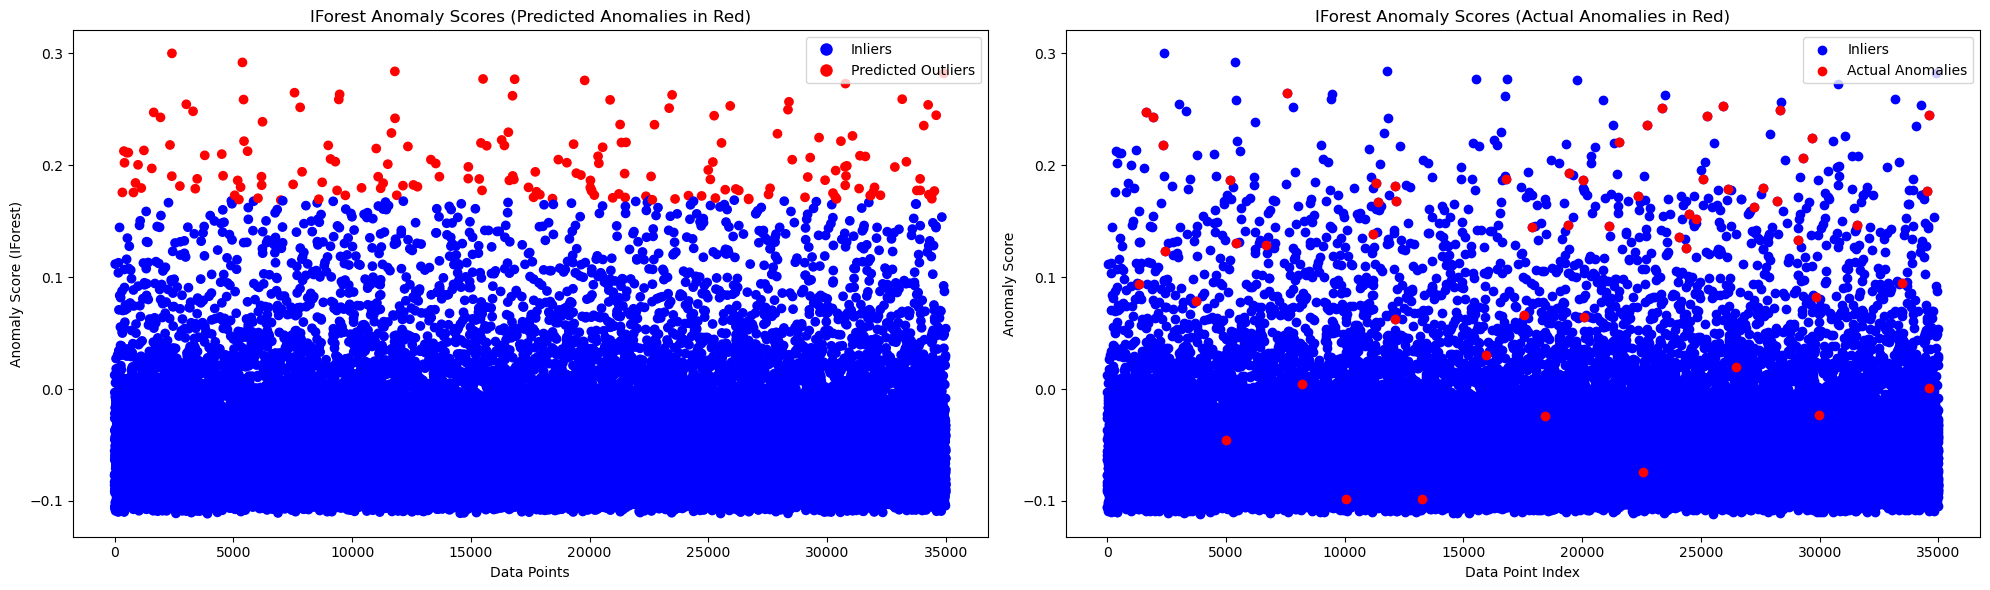

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Predicted Anomalies
axes[0].scatter(range(len(anomaly_scores_iforest)), anomaly_scores_iforest, c=np.where(anomalies_iforest, 'red', 'blue'), label='Inliers/Predicted Outliers')
axes[0].set_xlabel('Data Points')
axes[0].set_ylabel('Anomaly Score (IForest)')
axes[0].set_title('IForest Anomaly Scores (Predicted Anomalies in Red)')
# Adding a legend
scatter1_handles, scatter1_labels = axes[0].get_legend_handles_labels()
# Adding specific labels for colors
inliers_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers')
pred_outliers_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted Outliers')
axes[0].legend(handles=[inliers_patch, pred_outliers_patch])

# Plot 2: Actual Anomalies
axes[1].scatter(X_train_robustscaled.index, anomaly_scores_iforest, c='b', label='Inliers')
axes[1].scatter(X_train_robustscaled.index[y_train_subsample == 1], anomaly_scores_iforest[y_train_subsample == 1], c='r', label='Actual Anomalies')
axes[1].set_title('IForest Anomaly Scores (Actual Anomalies in Red)')
axes[1].set_xlabel('Data Point Index')
axes[1].set_ylabel('Anomaly Score')
axes[1].legend()

plt.tight_layout()
plt.show()

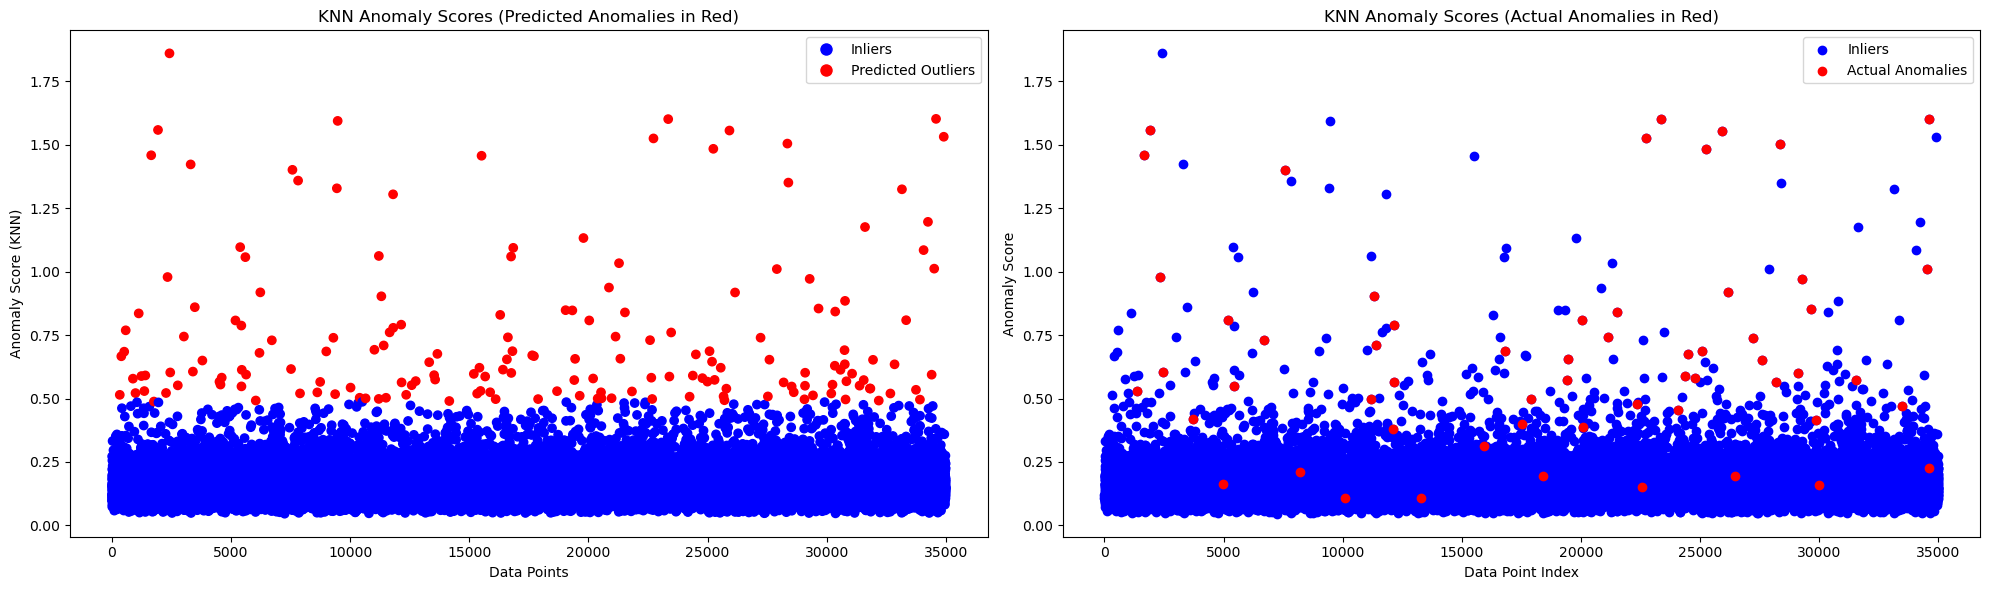

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Predicted Anomalies for KNN
axes[0].scatter(range(len(anomaly_scores_knn)), anomaly_scores_knn, c=np.where(anomalies_knn, 'red', 'blue'), label='Inliers/Predicted Outliers')
axes[0].set_xlabel('Data Points')
axes[0].set_ylabel('Anomaly Score (KNN)')
axes[0].set_title('KNN Anomaly Scores (Predicted Anomalies in Red)')
# Adding a legend
inliers_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers')
pred_outliers_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted Outliers')
axes[0].legend(handles=[inliers_patch, pred_outliers_patch])

# Plot 2: Actual Anomalies for KNN
axes[1].scatter(X_train_minmaxscaled.index, anomaly_scores_knn, c='b', label='Inliers')
axes[1].scatter(X_train_minmaxscaled.index[y_train_subsample == 1], anomaly_scores_knn[y_train_subsample == 1], c='r', label='Actual Anomalies')
axes[1].set_title('KNN Anomaly Scores (Actual Anomalies in Red)')
axes[1].set_xlabel('Data Point Index')
axes[1].set_ylabel('Anomaly Score')
axes[1].legend()

plt.tight_layout()
plt.show()


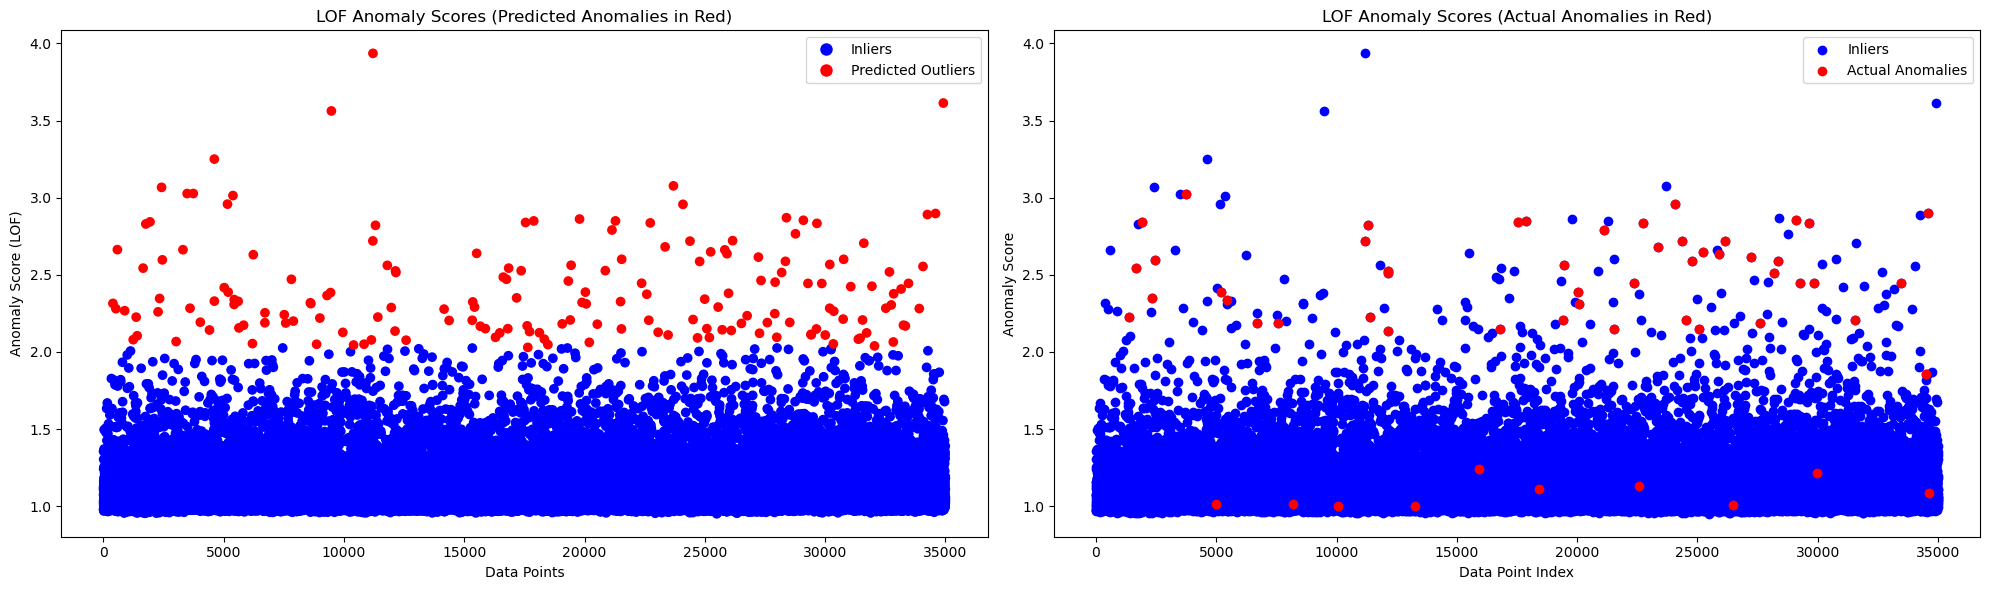

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Predicted Anomalies for LOF
axes[0].scatter(range(len(anomaly_scores_lof)), anomaly_scores_lof, c=np.where(anomalies_lof, 'red', 'blue'), label='Inliers/Predicted Outliers')
axes[0].set_xlabel('Data Points')
axes[0].set_ylabel('Anomaly Score (LOF)')
axes[0].set_title('LOF Anomaly Scores (Predicted Anomalies in Red)')
# Adding a legend
inliers_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Inliers')
pred_outliers_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predicted Outliers')
axes[0].legend(handles=[inliers_patch, pred_outliers_patch])

# Plot 2: Actual Anomalies for LOF
axes[1].scatter(X_train_minmaxscaled.index, anomaly_scores_lof, c='b', label='Inliers')
axes[1].scatter(X_train_minmaxscaled.index[y_train_subsample == 1], anomaly_scores_lof[y_train_subsample == 1], c='r', label='Actual Anomalies')
axes[1].set_title('LOF Anomaly Scores (Actual Anomalies in Red)')
axes[1].set_xlabel('Data Point Index')
axes[1].set_ylabel('Anomaly Score')
axes[1].legend()

plt.tight_layout()
plt.show()


### Heatmap of Anomaly Scores


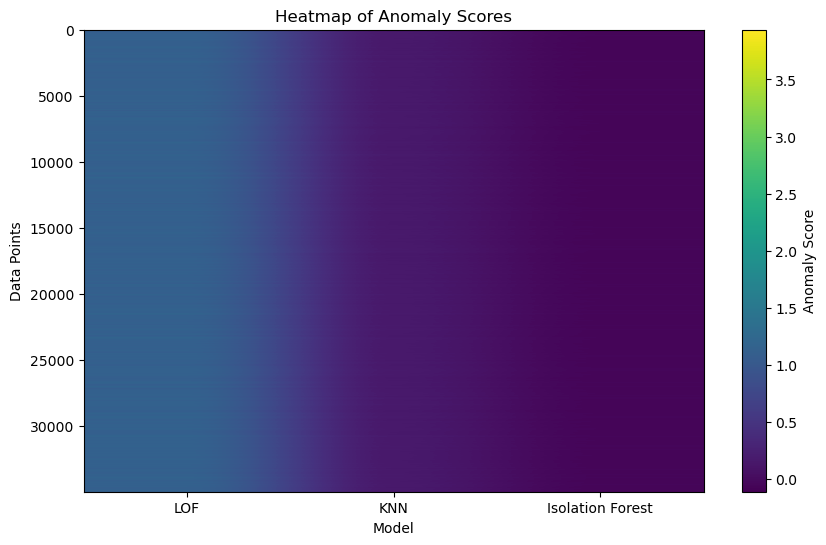

In [12]:
anomaly_scores_matrix = np.column_stack((anomaly_scores_lof, anomaly_scores_knn, anomaly_scores_iforest))


# Plot heatmap of anomaly scores matrix
plt.figure(figsize=(10, 6))
plt.imshow(anomaly_scores_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Anomaly Score')
plt.xlabel('Model')
plt.ylabel('Data Points')
plt.title('Heatmap of Anomaly Scores')
plt.xticks(ticks=np.arange(3), labels=['LOF', 'KNN', 'Isolation Forest'])
plt.show()


### Histogram of Anomaly Scores


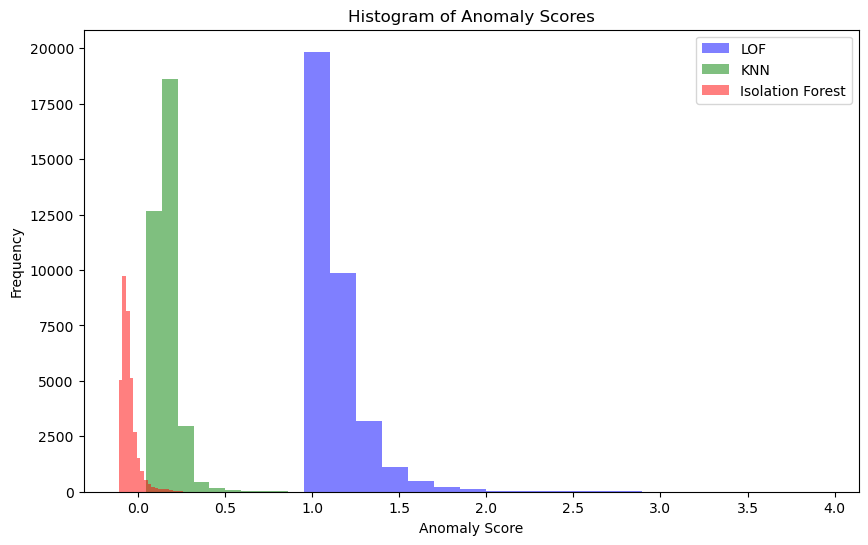

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores_lof, bins=20, alpha=0.5, color='blue', label='LOF')
plt.hist(anomaly_scores_knn, bins=20, alpha=0.5, color='green', label='KNN')
plt.hist(anomaly_scores_iforest, bins=20, alpha=0.5, color='red', label='Isolation Forest')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Anomaly Scores')
plt.legend()
plt.show()

# SHAP

### SHAP for IForest

In [14]:
# Number of rows in the subsample
explainer_iforest = shap.Explainer(IForest_model)
shap_values_iforest = explainer_iforest(X_train_robustscaled)

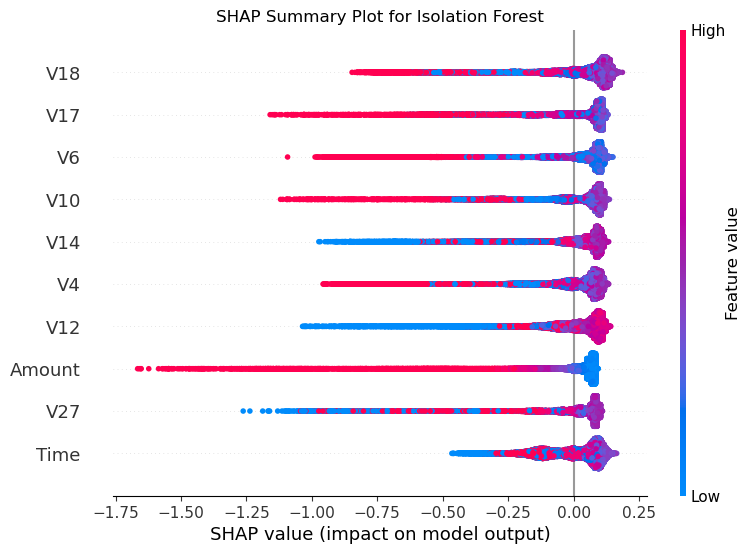

In [104]:
shap.summary_plot(shap_values_iforest, X_train_robustscaled, show= False, max_display=10)
plt.title("SHAP Summary Plot for Isolation Forest")
plt.show()


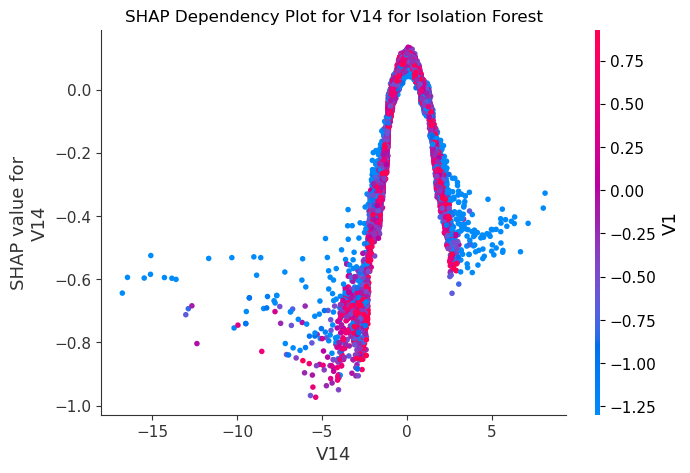

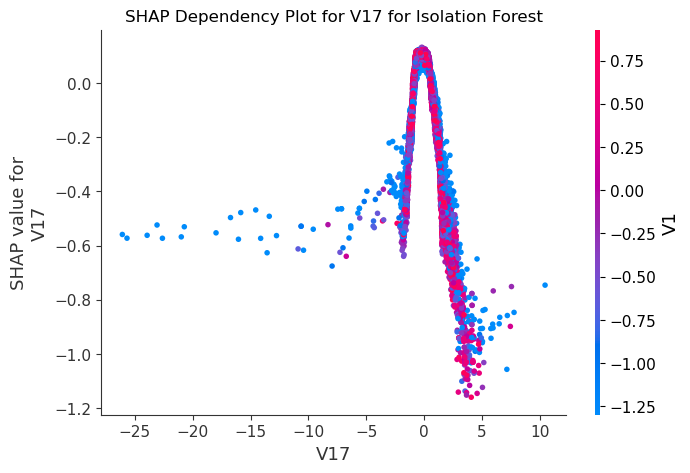

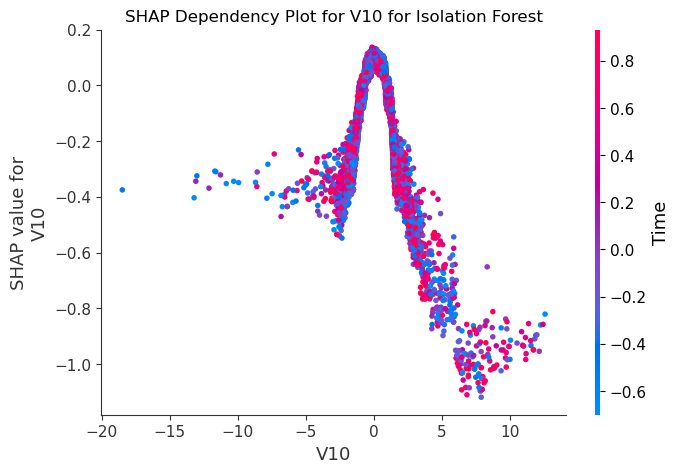

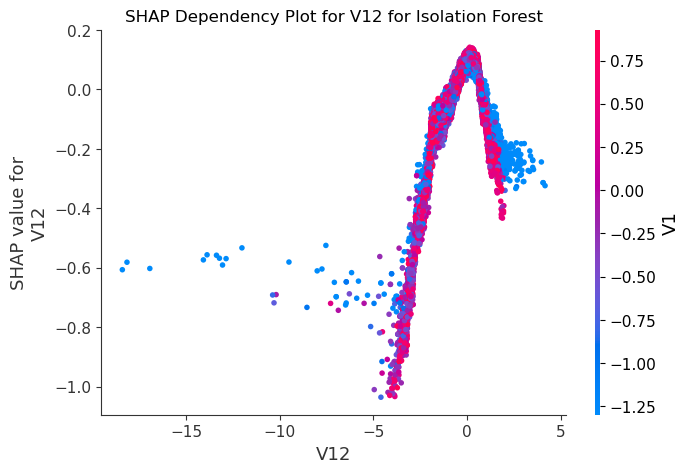

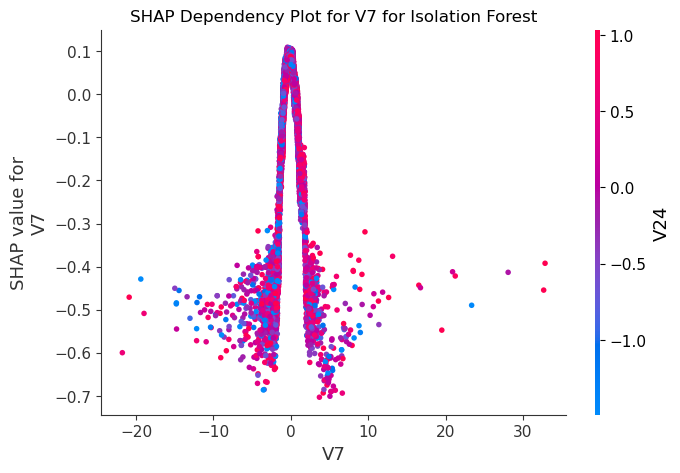

In [111]:
shap.dependence_plot('V14', shap_values_iforest.values, X_train_robustscaled, show=False)
plt.title("SHAP Dependency Plot for V14 for Isolation Forest")
plt.show()
shap.dependence_plot('V17', shap_values_iforest.values, X_train_robustscaled, show=False)
plt.title("SHAP Dependency Plot for V17 for Isolation Forest")
plt.show()
shap.dependence_plot('V10', shap_values_iforest.values, X_train_robustscaled, show=False)
plt.title("SHAP Dependency Plot for V10 for Isolation Forest")
plt.show()
shap.dependence_plot('V12', shap_values_iforest.values, X_train_robustscaled, show=False)
plt.title("SHAP Dependency Plot for V12 for Isolation Forest")
plt.show()
shap.dependence_plot('V7', shap_values_iforest.values, X_train_robustscaled, show=False)
plt.title("SHAP Dependency Plot for V7 for Isolation Forest")
plt.show()


### SHAP for LOF and KNN Using a Surrogate Model

#### LOF

In [17]:

# Train a surrogate model
y_lof = LOF_model.predict(X_train_minmaxscaled)
rf_surrogate_lof = RandomForestClassifier()
rf_surrogate_lof.fit(X_train_minmaxscaled, y_lof)

# Explain the surrogate model with SHAP
explainer_lof = shap.Explainer(rf_surrogate_lof, X_train_minmaxscaled)
shap_values_lof = explainer_lof(X_train_minmaxscaled)



100%|===================| 69973/70000 [05:31<00:00]        

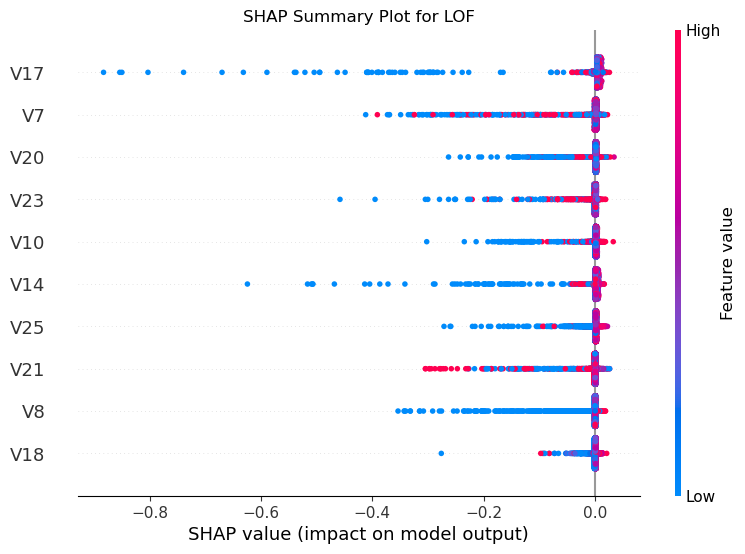

In [103]:
shap.summary_plot(shap_values_lof[:,:,0], X_train_minmaxscaled, show=False, max_display=10)
plt.title("SHAP Summary Plot for LOF")
plt.show()

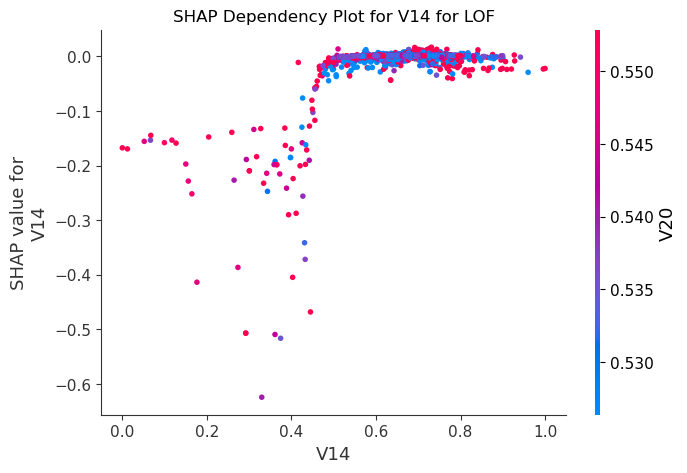

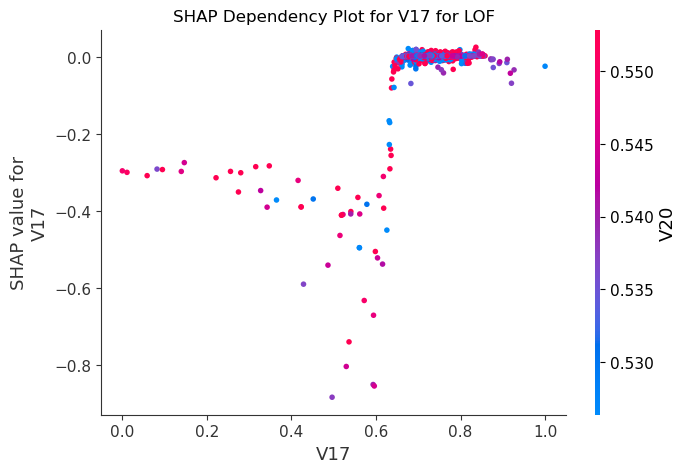

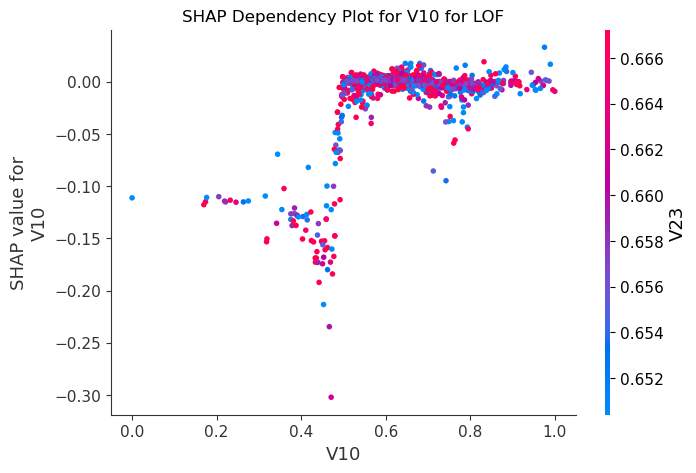

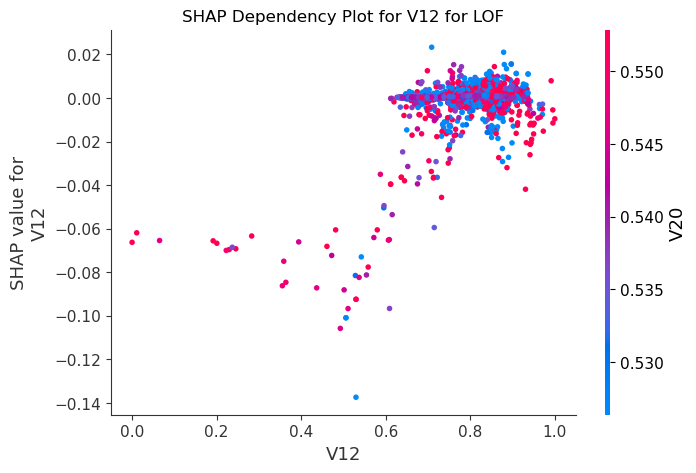

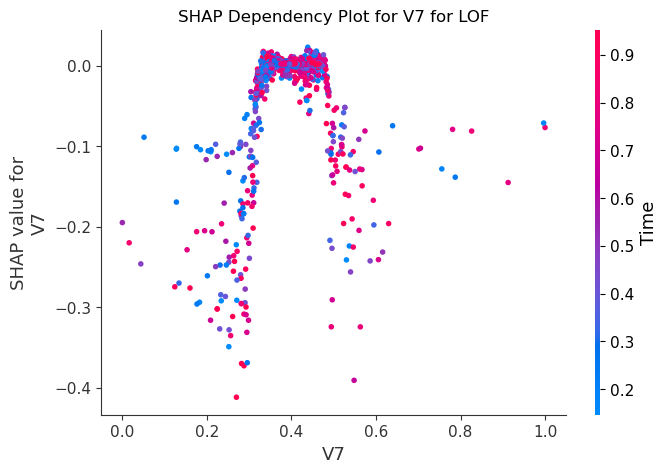

In [112]:
shap.dependence_plot('V14', shap_values_lof.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V14 for LOF")
plt.show()
shap.dependence_plot('V17', shap_values_lof.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V17 for LOF")
plt.show()
shap.dependence_plot('V10', shap_values_lof.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V10 for LOF")
plt.show()
shap.dependence_plot('V12', shap_values_lof.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V12 for LOF")
plt.show()
shap.dependence_plot('V7', shap_values_lof.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V7 for LOF")
plt.show()


####  KNN

In [19]:
# Train a surrogate model
y_knn = KNN_model.predict(X_train_minmaxscaled)
rf_surrogate_knn = RandomForestClassifier()
rf_surrogate_knn.fit(X_train_minmaxscaled, y_knn)

# Explain the surrogate model with SHAP
explainer_knn = shap.Explainer(rf_surrogate_knn, X_train_minmaxscaled)
shap_values_knn = explainer_knn(X_train_minmaxscaled)

100%|===================| 69826/70000 [04:13<00:00]        

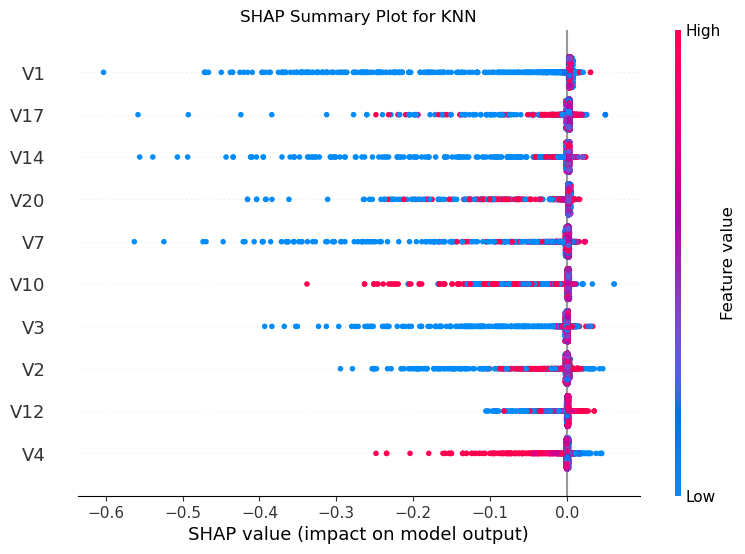

In [105]:
# Visualization
shap.summary_plot(shap_values_knn[:,:,0], X_train_minmaxscaled, show=False, max_display=10)
plt.title("SHAP Summary Plot for KNN")
plt.show()

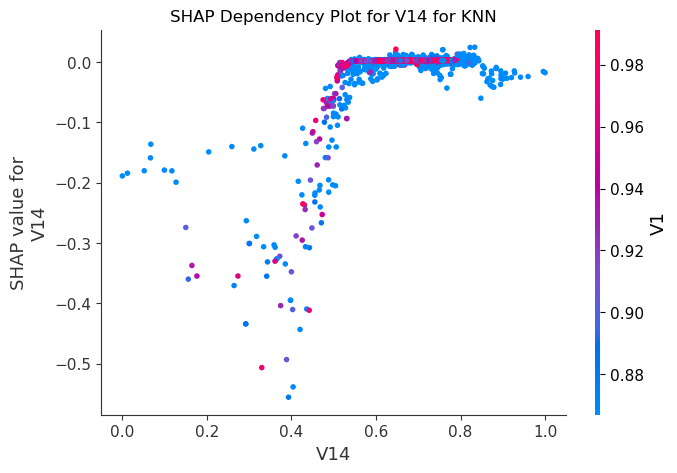

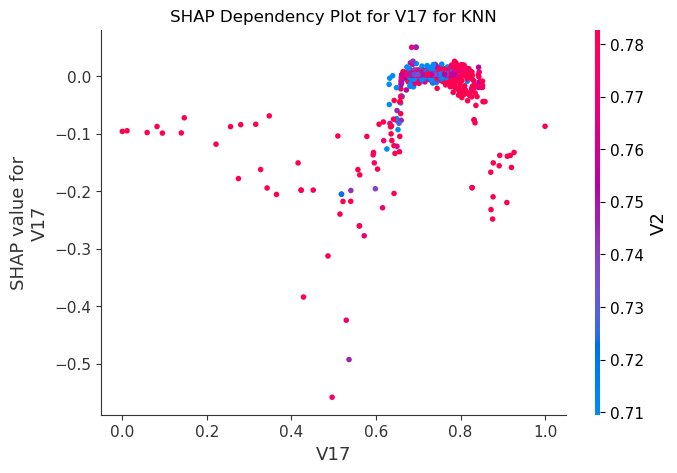

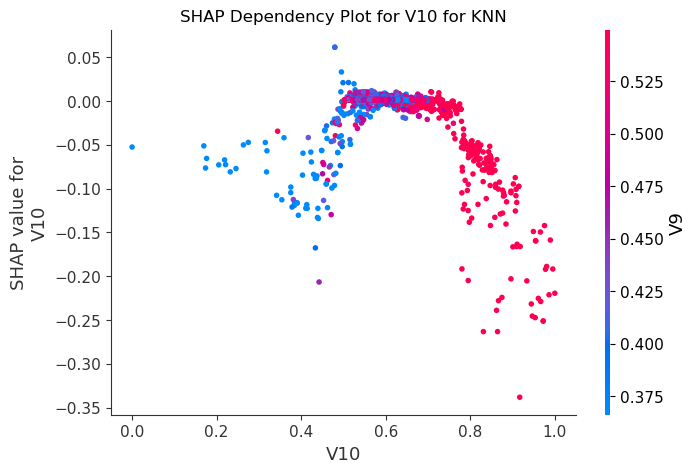

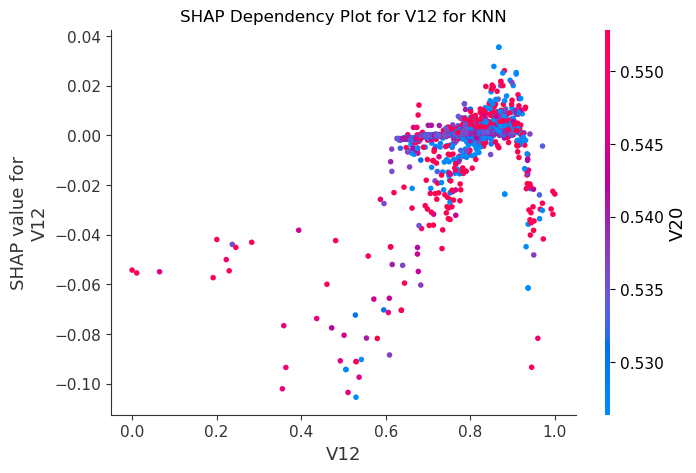

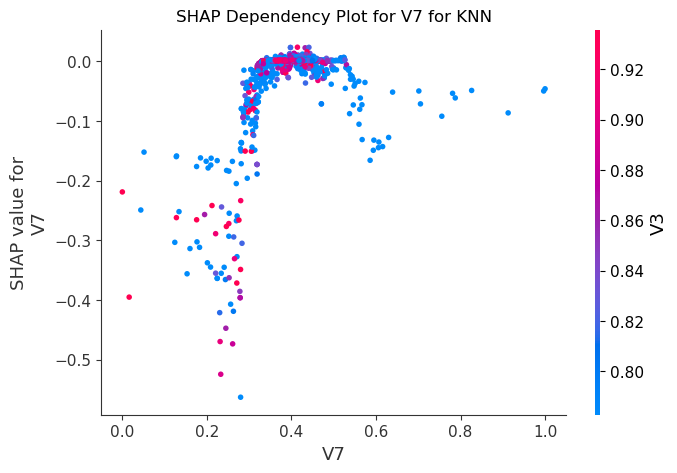

In [113]:
shap.dependence_plot('V14', shap_values_knn.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V14 for KNN")
plt.show()
shap.dependence_plot('V17', shap_values_knn.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V17 for KNN")
plt.show()
shap.dependence_plot('V10', shap_values_knn.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V10 for KNN")
plt.show()
shap.dependence_plot('V12', shap_values_knn.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V12 for KNN")
plt.show()
shap.dependence_plot('V7', shap_values_knn.values[:,:,0], X_train_minmaxscaled, show=False)
plt.title("SHAP Dependency Plot for V7 for KNN")
plt.show()


In [81]:
# Identify where models agree or disagree on outlier predictions
agreement = (anomalies_iforest == anomalies_knn) & (anomalies_knn == anomalies_lof) &(anomalies_iforest == anomalies_lof) & (y_train_subsample==1)
disagreement = (anomalies_iforest != anomalies_knn) | (anomalies_knn != anomalies_lof) | (anomalies_iforest != anomalies_lof)
disagreement = disagreement & (y_train_subsample == 1)
# Indices of agreeing and disagreeing data points
agree_indices = np.where(agreement)[0]
disagree_indices = np.where(disagreement)[0]

In [82]:
# SHAP values for agreeing data points
shap_values_iforest_agree = shap_values_iforest[agree_indices, :]
shap_values_knn_agree = shap_values_knn[agree_indices, :]
shap_values_lof_agree = shap_values_lof[agree_indices, :]


# SHAP values for disagreeing data points
shap_values_iforest_disagree = shap_values_iforest[disagree_indices, :]
shap_values_knn_disagree = shap_values_knn[disagree_indices, :]
shap_values_lof_disagree = shap_values_lof[disagree_indices, :]

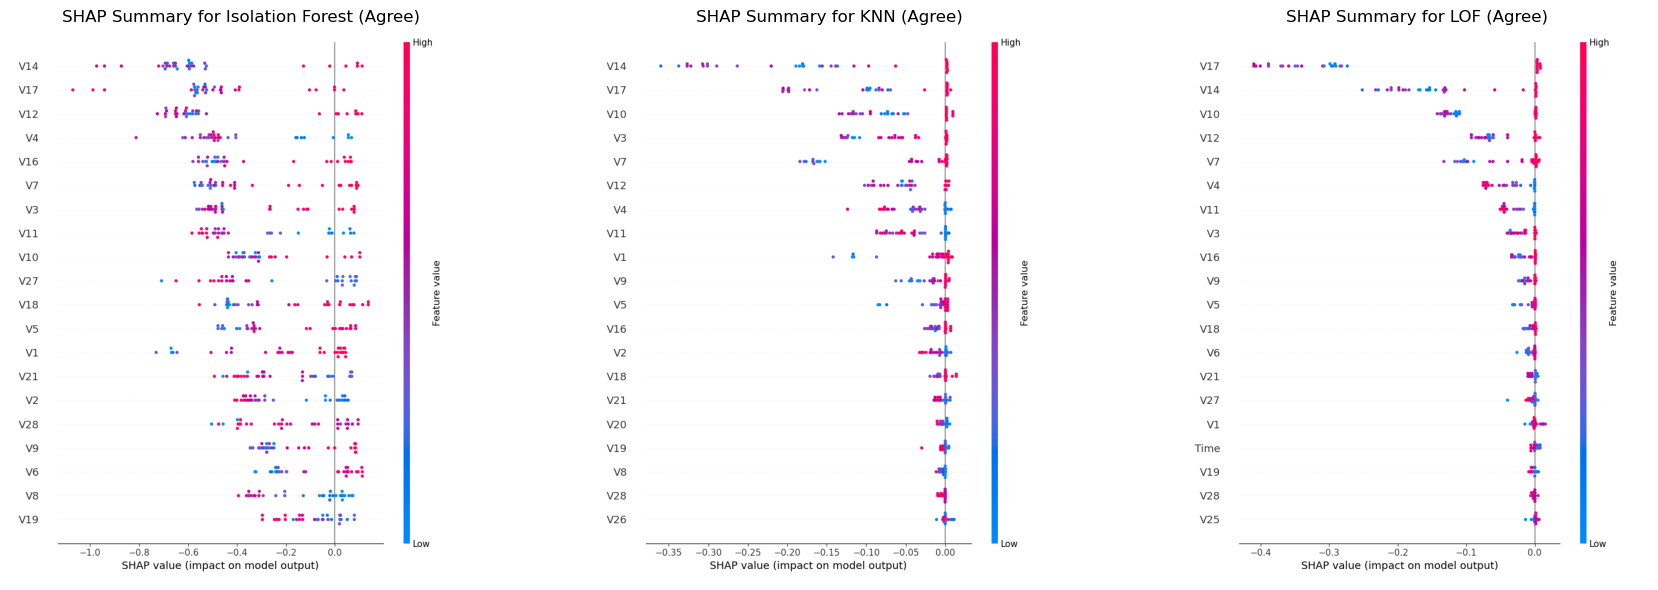

In [83]:
# Temporary files to save the SHAP plots
with NamedTemporaryFile(suffix=".png") as tmp1, NamedTemporaryFile(suffix=".png") as tmp2, NamedTemporaryFile(suffix=".png") as tmp3:
    # Plot 1: SHAP Summary for Isolation Forest (Agree)
    shap.summary_plot(shap_values_iforest_agree.values, X_train_robustscaled.iloc[agree_indices],  show=False)
   
    plt.savefig(tmp1.name)
    plt.close()

    # Plot 2: SHAP Summary for KNN (Agree)
    shap.summary_plot(shap_values_knn_agree[:,:,0], X_train_minmaxscaled.iloc[agree_indices],  show=False)
    
    plt.savefig(tmp2.name)
    plt.close()

    # Plot 3: SHAP Summary for LOF (Agree)
    shap.summary_plot(shap_values_lof_agree[:,:,0], X_train_minmaxscaled.iloc[agree_indices],  show=False)
    
    plt.savefig(tmp3.name)
    plt.close()

    # Create a new figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Load and display each saved SHAP plot
    img1 = plt.imread(tmp1.name)
    img2 = plt.imread(tmp2.name)
    img3 = plt.imread(tmp3.name)

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('SHAP Summary for Isolation Forest (Agree)')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('SHAP Summary for KNN (Agree)')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('SHAP Summary for LOF (Agree)')

    plt.tight_layout()
    plt.show()

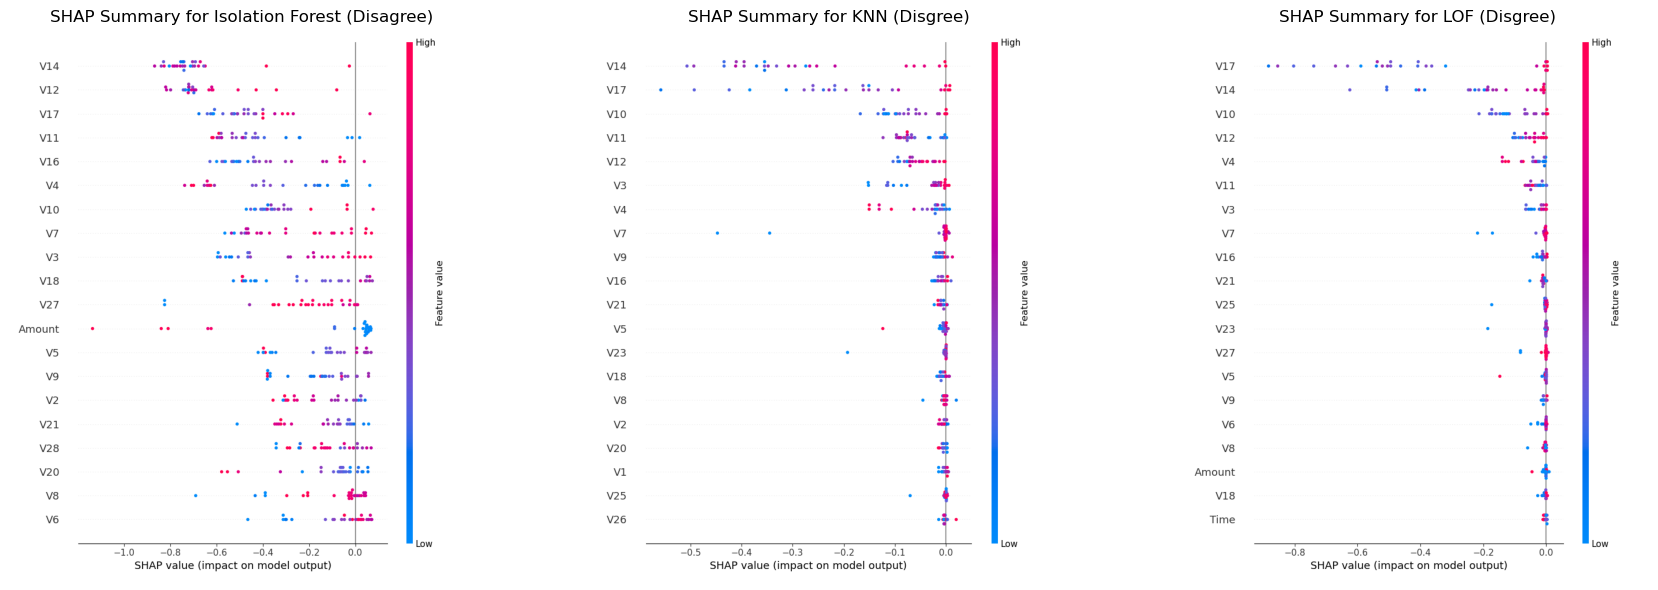

In [84]:
# Temporary files to save the SHAP plots
with NamedTemporaryFile(suffix=".png") as tmp1, NamedTemporaryFile(suffix=".png") as tmp2, NamedTemporaryFile(suffix=".png") as tmp3:
    # Plot 1: SHAP Summary for Isolation Forest (Agree)
    shap.summary_plot(shap_values_iforest_disagree.values, X_train_robustscaled.iloc[disagree_indices],  show=False)
   
    plt.savefig(tmp1.name)
    plt.close()

    # Plot 2: SHAP Summary for KNN (Agree)
    shap.summary_plot(shap_values_knn_disagree[:,:,0], X_train_minmaxscaled.iloc[disagree_indices],  show=False)
    
    plt.savefig(tmp2.name)
    plt.close()

    # Plot 3: SHAP Summary for LOF (Agree)
    shap.summary_plot(shap_values_lof_disagree[:,:,0], X_train_minmaxscaled.iloc[disagree_indices],  show=False)
    
    plt.savefig(tmp3.name)
    plt.close()

    # Create a new figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Load and display each saved SHAP plot
    img1 = plt.imread(tmp1.name)
    img2 = plt.imread(tmp2.name)
    img3 = plt.imread(tmp3.name)

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('SHAP Summary for Isolation Forest (Disagree)')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('SHAP Summary for KNN (Disgree)')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('SHAP Summary for LOF (Disgree)')

    plt.tight_layout()
    plt.show()

In [27]:
shap_values_iforest_outliers = shap_values_iforest[anomalies_iforest]
shap_values_iforest_non_outliers = shap_values_iforest[non_anomalies_iforest]

shap_values_knn_outliers = shap_values_knn[anomalies_knn]
shap_values_knn_non_outliers = shap_values_knn[non_anomalies_knn]

shap_values_lof_outliers = shap_values_lof[anomalies_lof]
shap_values_lof_non_outliers = shap_values_lof[non_anomalies_lof]

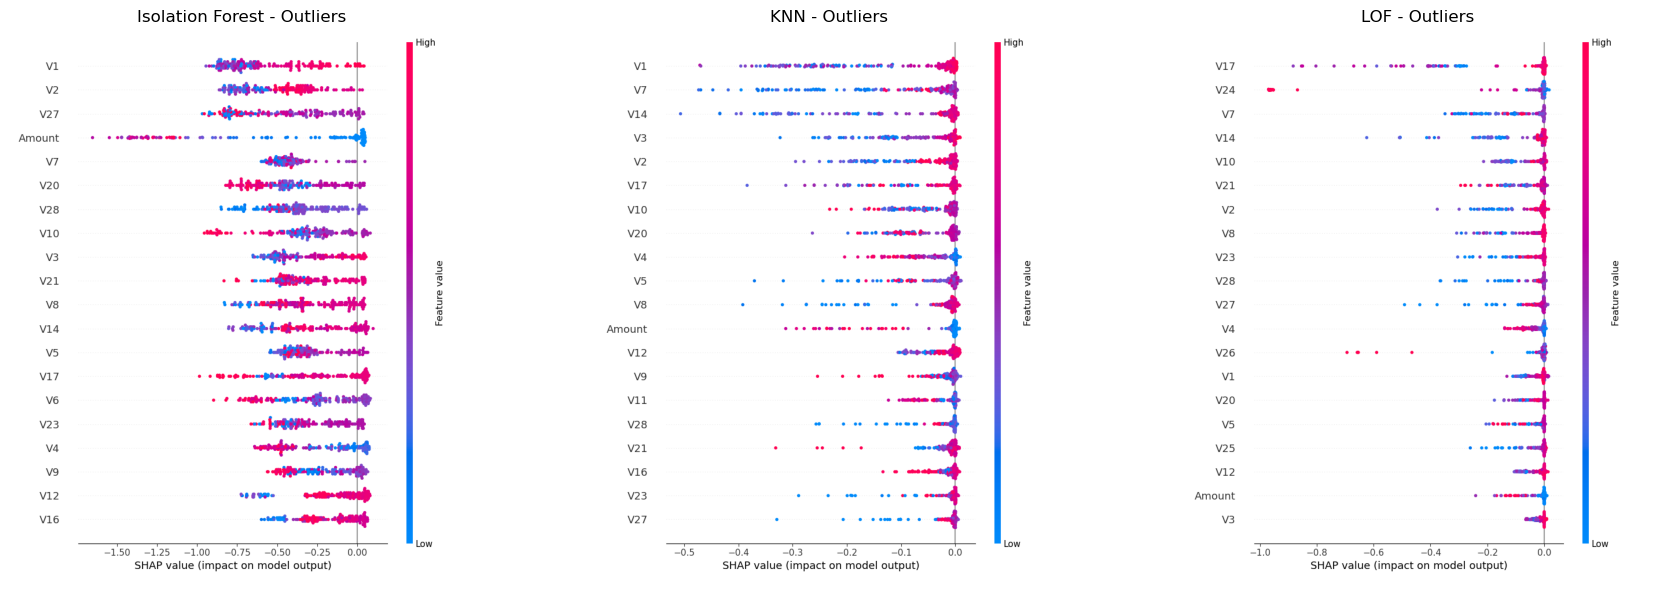

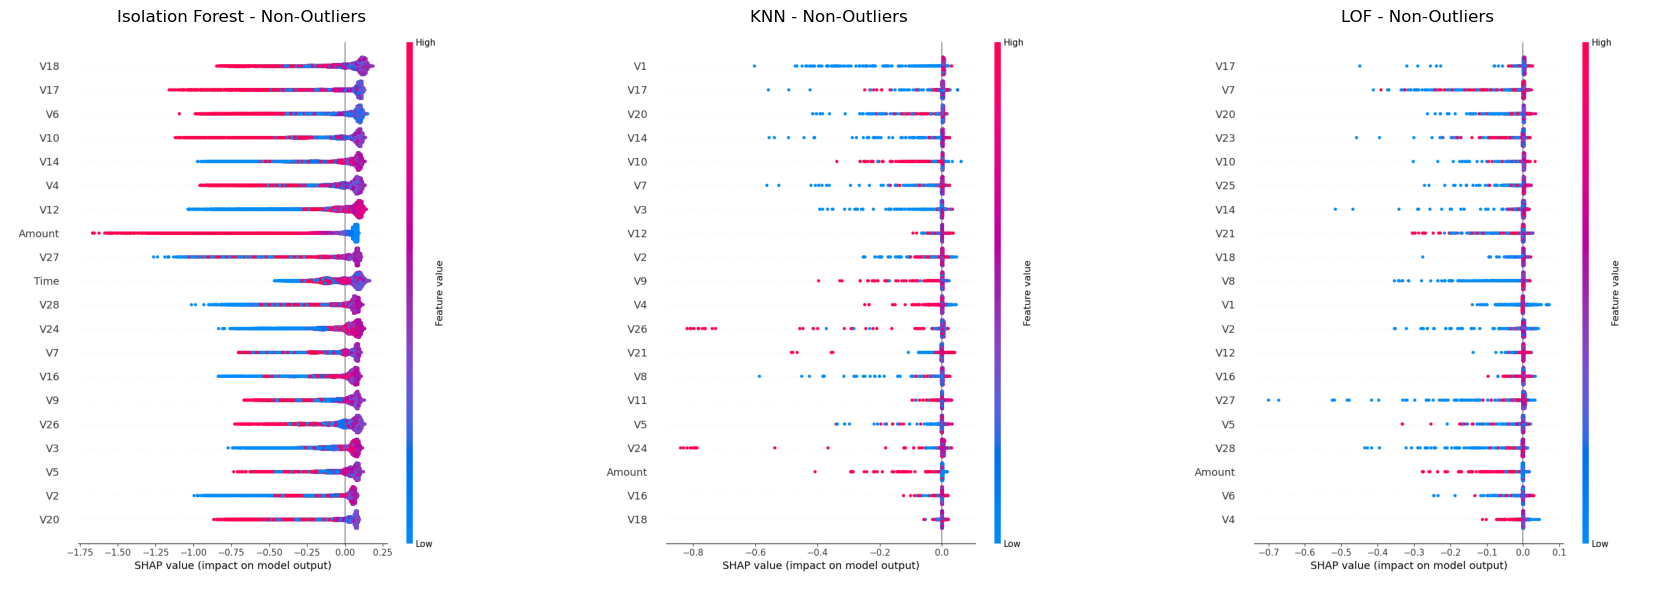

In [28]:
# Temporary files to save the SHAP plots
with NamedTemporaryFile(suffix=".png") as tmp1, NamedTemporaryFile(suffix=".png") as tmp2, NamedTemporaryFile(suffix=".png") as tmp3:
    # Plot 1: SHAP Summary for Isolation Forest (Outliers)
    shap.summary_plot(shap_values_iforest_outliers.values, X_train_robustscaled.iloc[anomalies_iforest], show=False)
    plt.savefig(tmp1.name)
    plt.close()

    # Plot 2: SHAP Summary for KNN (Outliers)
    shap.summary_plot(shap_values_knn_outliers[:,:,0], X_train_minmaxscaled.iloc[anomalies_knn], show=False)
    plt.savefig(tmp2.name)
    plt.close()

    # Plot 3: SHAP Summary for LOF (Outliers)
    shap.summary_plot(shap_values_lof_outliers[:,:,0], X_train_minmaxscaled.iloc[anomalies_lof],  show=False)
    plt.savefig(tmp3.name)
    plt.close()

    # Create a new figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Load and display each saved SHAP plot
    img1 = plt.imread(tmp1.name)
    img2 = plt.imread(tmp2.name)
    img3 = plt.imread(tmp3.name)

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Isolation Forest - Outliers')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('KNN - Outliers')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('LOF - Outliers')

    plt.tight_layout()
    plt.show()

with NamedTemporaryFile(suffix=".png") as tmp1, NamedTemporaryFile(suffix=".png") as tmp2, NamedTemporaryFile(suffix=".png") as tmp3:
    # Plot 1: SHAP Summary for Isolation Forest (Non-Outliers)
    shap.summary_plot(shap_values_iforest_non_outliers.values, X_train_robustscaled.iloc[non_anomalies_iforest],  show=False)
    plt.savefig(tmp1.name)
    plt.close()

    # Plot 2: SHAP Summary for KNN (Non-Outliers)
    shap.summary_plot(shap_values_knn_non_outliers[:,:,0], X_train_minmaxscaled.iloc[non_anomalies_knn], show=False)
    plt.savefig(tmp2.name)
    plt.close()

    # Plot 3: SHAP Summary for LOF (Non-Outliers)
    shap.summary_plot(shap_values_lof_non_outliers[:,:,0], X_train_minmaxscaled.iloc[non_anomalies_lof],  show=False)
    plt.savefig(tmp3.name)
    plt.close()

    # Create a new figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Load and display each saved SHAP plot
    img1 = plt.imread(tmp1.name)
    img2 = plt.imread(tmp2.name)
    img3 = plt.imread(tmp3.name)

    axes[0].imshow(img1)
    axes[0].axis('off')
    axes[0].set_title('Isolation Forest - Non-Outliers')

    axes[1].imshow(img2)
    axes[1].axis('off')
    axes[1].set_title('KNN - Non-Outliers')

    axes[2].imshow(img3)
    axes[2].axis('off')
    axes[2].set_title('LOF - Non-Outliers')

    plt.tight_layout()
    plt.show()


In [29]:
shap.initjs()
shap.force_plot(explainer_iforest.expected_value, shap_values_iforest.values[anomalies_iforest,:], X_train_robustscaled.iloc[anomalies_iforest,:])

In [87]:
shap.initjs()
shap.force_plot(explainer_knn.expected_value[0], shap_values_knn.values[anomalies_knn,:][:,:,0], X_train_minmaxscaled.iloc[anomalies_knn,:])

In [89]:
shap.initjs()
shap.force_plot(explainer_lof.expected_value[0], shap_values_lof.values[anomalies_lof,:][:,:,0], X_train_minmaxscaled.iloc[anomalies_lof,:])